# Ejercicio Ridge, Lasso y ElasticNet
Para este ejercicio vas a trabajar con datos de ventas de una empresa que fabrica muebles en España. Esta empresa es una Pyme que demanda conocer de antemano qué ingresos va a tener cada mes, ya que necesita pedir un anticipio a su entidad financiera de cara a poder abastecerse de materia prima al comenzar el mes. Como desconoce cuánto tiene que pedir, tira al alza y acaba pagando muchos intereses. El objetivo es reducir estos gastos.

En las bases de datos de la empresa constan todos los gastos en publicidad y ventas, para cada uno de los meses desde su fundación (hace más de 15 años).

Dado que los presupuestos de marketing se cierran al principio de cada mes, la empresa necesita un modelo predictivo que le anticipe las ventas que conseguirá a final de mes en función de los gastos que realizará en marketing.

Para ello tendrás que utilizar tanto modelos de regresión normales, como regularizados.

1. Carga los datos y realiza un pequeño análisis exploratorio. Mira a ver cómo se relaciona las ventas con el resto de variables.
2. Crea varios modelos y modifica los hiperparámetros necesarios para mejorar el performance del modelo.
3. Interpreta los resultados. Traduce a una fórmula tu mejor modelo (escribir la fórmula simplemente). ¿Cuánto cambian las ventas si aumentamos la inversión en radio un punto más? ¿Y si aumentamos la inversión en TV o periódicos?

## Import libraries 

In [922]:
import pandas as pd
import numpy as np
from sklearn import linear_model, metrics, model_selection
from sklearn.linear_model import ElasticNet
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
import seaborn as sns

## Exploratory Data Analysis 

In [923]:
muebles = pd.read_csv("data\\Advertising.csv")
muebles


,Unnamed: 0,TV,radio,newpaper,sales
0,0,230.1,37.8,6s9.2,22100.0
1,1,44.5,39.3,45.1,10400.0
2,2,17.2,45.9,69.3,9300.0
3,3,151.5,41.3,58.5,18500.0
4,4,180.8,10.8,58.4,12900.0
...,...,...,...,...,...
195,195,38.2,3.7,13.8,7600.0
196,196,94.2,4.9,8.1,9700.0
197,197,177.0,9.3,6.4,12800.0
198,198,283.6,42.0,66.2,25500.0


In [924]:
muebles.drop([0],inplace=True)

In [925]:
muebles["newpaper"] = muebles["newpaper"].astype(float)

In [926]:
muebles

,Unnamed: 0,TV,radio,newpaper,sales
1,1,44.5,39.3,45.1,10400.0
2,2,17.2,45.9,69.3,9300.0
3,3,151.5,41.3,58.5,18500.0
4,4,180.8,10.8,58.4,12900.0
5,5,8.7,48.9,75.0,7200.0
...,...,...,...,...,...
195,195,38.2,3.7,13.8,7600.0
196,196,94.2,4.9,8.1,9700.0
197,197,177.0,9.3,6.4,12800.0
198,198,283.6,42.0,66.2,25500.0


In [927]:
muebles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 1 to 199
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  199 non-null    int64  
 1   TV          199 non-null    float64
 2   radio       199 non-null    float64
 3   newpaper    199 non-null    float64
 4   sales       199 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 7.9 KB


In [928]:
muebles.describe()

,Unnamed: 0,TV,radio,newpaper,sales
count,199.000000,199.000000,199.000000,199.000000,199.000000
mean,100.000000,146.625126,23.190955,30.359799,13981.909548
std,57.590508,85.867111,14.848182,21.659246,5198.861022
min,1.000000,0.700000,0.000000,0.300000,1600.000000
25%,50.500000,74.050000,9.950000,12.700000,10350.000000
50%,100.000000,149.700000,22.500000,25.600000,12900.000000
75%,149.500000,218.450000,36.400000,44.700000,17350.000000
max,199.000000,296.400000,49.600000,114.000000,27000.000000


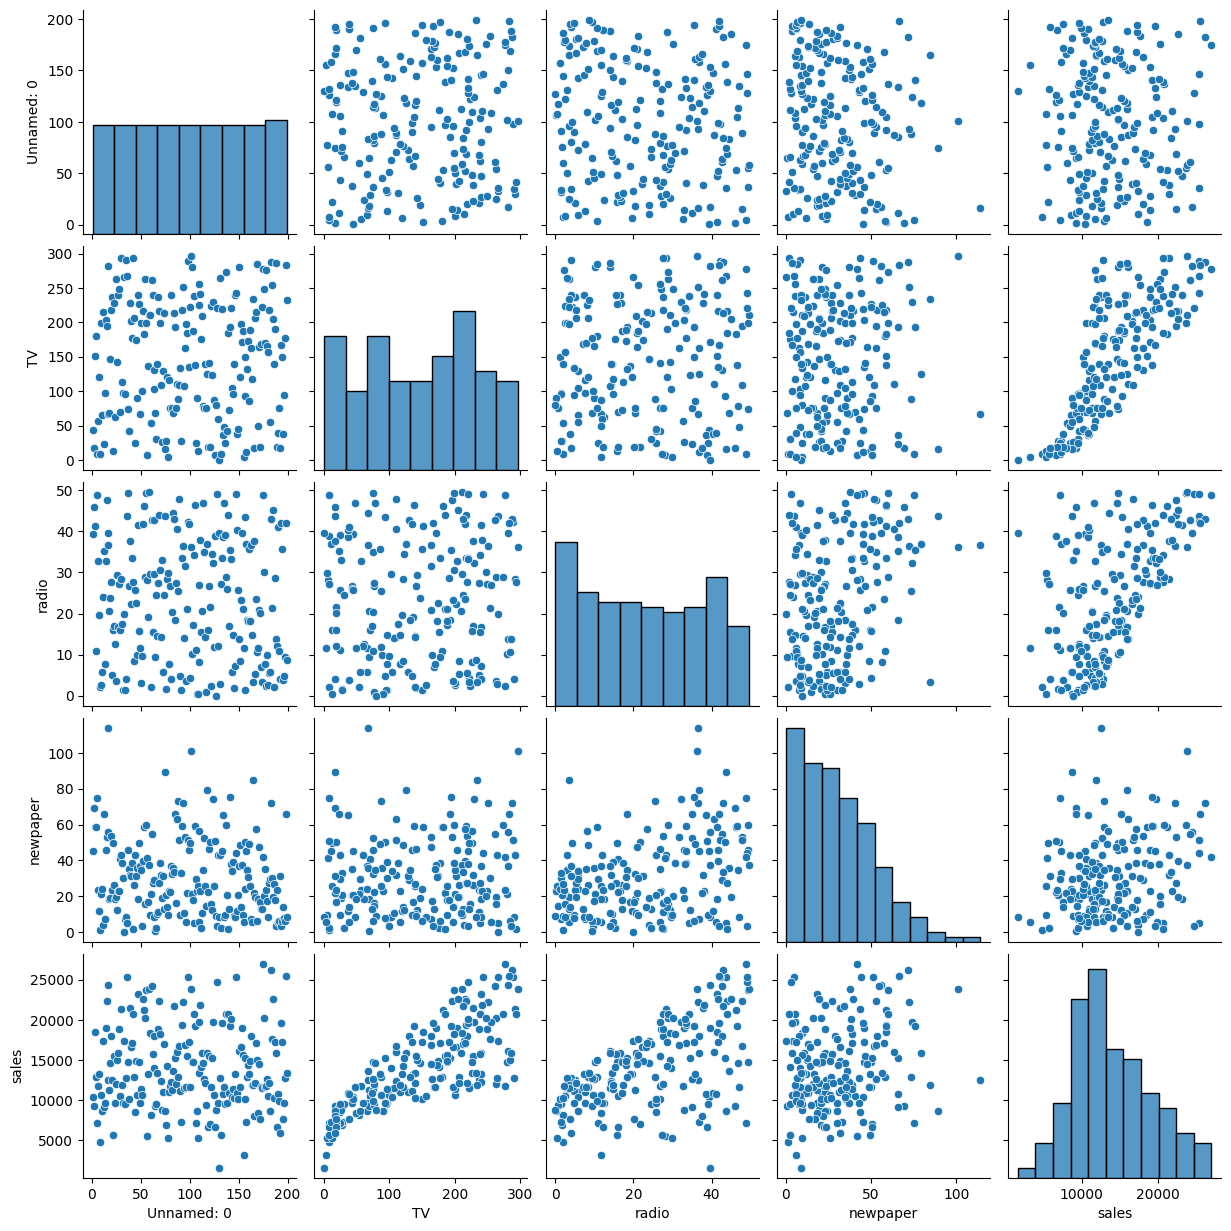

In [929]:
sns.pairplot(muebles)

<Axes: >

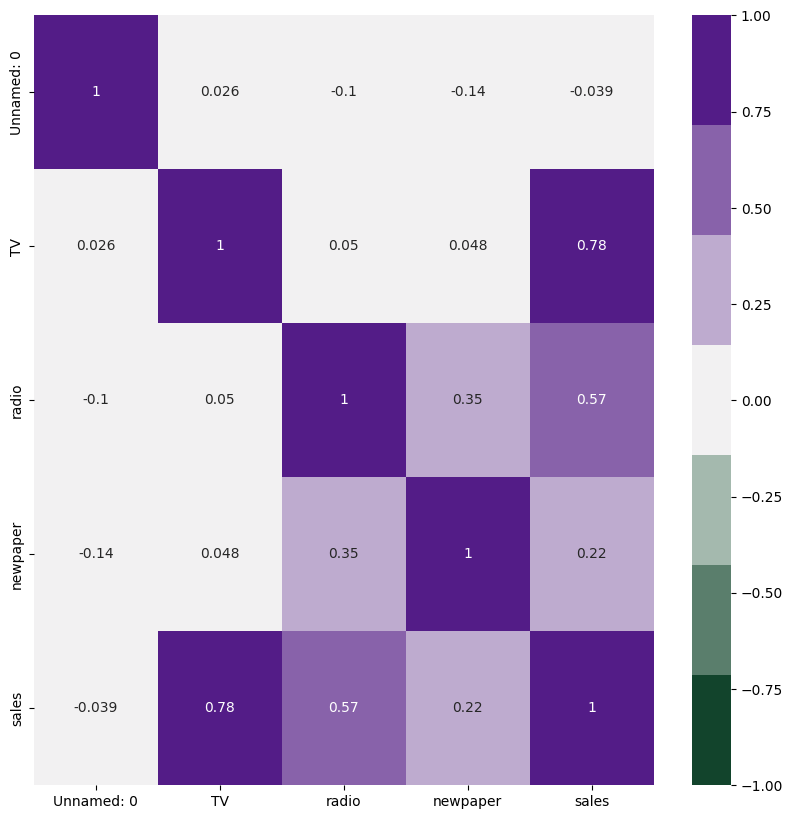

In [930]:
plt.figure(figsize=(10,10))
sns.heatmap(muebles.corr(),
           vmin=-1,
           vmax=1,
           cmap=sns.diverging_palette(145, 280, s=85, l=25, n=7),
           annot=True)

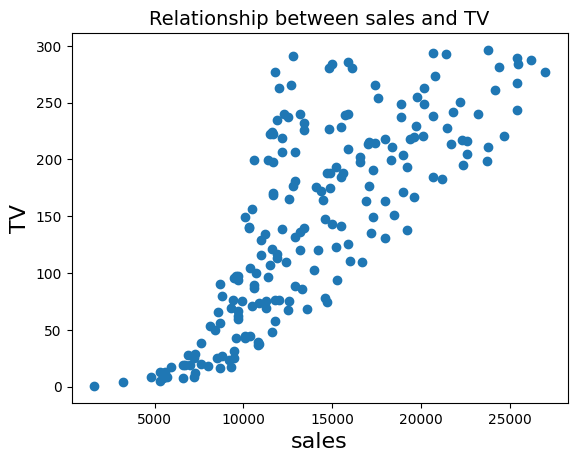

In [931]:
plt.scatter(muebles["sales"], muebles["TV"])
plt.xlabel("sales", fontsize=16)
plt.ylabel("TV", fontsize=16)
plt.title("Relationship between sales and TV", fontsize=14)
plt.show()

## Modelado

In [932]:
n_split = 160
X_train = muebles.iloc[:n_split,1:-1]
X_test = muebles.iloc[n_split:,1:-1]
y_train = muebles.iloc[:n_split,-1]
y_test = muebles.iloc[n_split:,-1]  

In [933]:
X_train

,TV,radio,newpaper
1,44.5,39.3,45.1
2,17.2,45.9,69.3
3,151.5,41.3,58.5
4,180.8,10.8,58.4
5,8.7,48.9,75.0
...,...,...,...
156,93.9,43.5,50.5
157,149.8,1.3,24.3
158,11.7,36.9,45.2
159,131.7,18.4,34.6


In [934]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(160, 3)
(39, 3)
(160,)
(39,)


In [935]:
from sklearn.preprocessing import StandardScaler

std_scale = StandardScaler()
std_scale.fit(X_train) #Se extraen la media y desviación típica
X_train_scal = std_scale.transform(X_train) #Se aplica esas medidas
X_test_scal = std_scale.transform(X_test) #Todo lo que se aplica a X_train ha de aplicarse a X_test

lm_scal = LinearRegression()
lm_scal.fit(X_train_scal, y_train)

predictions_2 = lm_scal.predict(X_test_scal)

intercept_scal = lm_scal.intercept_
features_std = pd.DataFrame(lm_scal.coef_, X_train.columns, columns=['coefficient'])

features_std.sort_values('coefficient', ascending=False)

,coefficient
TV,4015.200205
radio,2625.686815
newpaper,-35.835607


## Regresión polinómica

In [943]:
X = muebles[["TV"]]
X

,TV
1,44.5
2,17.2
3,151.5
4,180.8
5,8.7
...,...
195,38.2
196,94.2
197,177.0
198,283.6


In [944]:
y = muebles["sales"]
y

1      10400.0
2       9300.0
3      18500.0
4      12900.0
5       7200.0
        ...   
195     7600.0
196     9700.0
197    12800.0
198    25500.0
199    13400.0
Name: sales, Length: 199, dtype: float64

In [945]:
lin_reg = LinearRegression()

In [946]:
lin_reg.fit(X, y)

LinearRegression()

In [947]:
lin_reg.score(X,y)

0.610336570867759

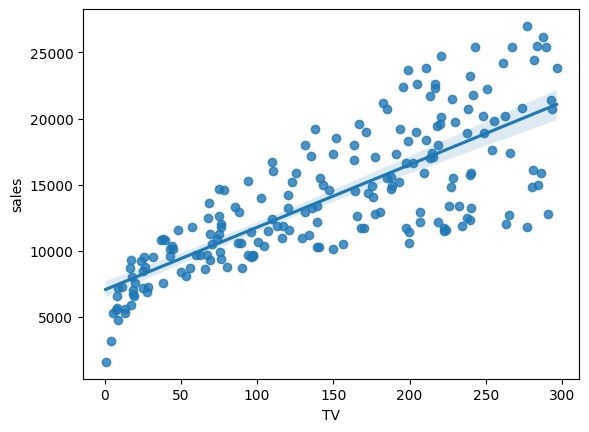

In [948]:
sns.regplot(data = muebles,
           x = "TV",
           y = "sales");

### Regresión de grado 2

In [949]:
X = muebles.iloc[:, 1:2].values
y = muebles.iloc[:, -1].values

In [950]:
X

array([[ 44.5],
       [ 17.2],
       [151.5],
       [180.8],
       [  8.7],
       [ 57.5],
       [120.2],
       [  8.6],
       [199.8],
       [ 66.1],
       [214.7],
       [ 23.8],
       [ 97.5],
       [204.1],
       [195.4],
       [ 67.8],
       [281.4],
       [ 69.2],
       [147.3],
       [218.4],
       [237.4],
       [ 13.2],
       [228.3],
       [ 62.3],
       [262.9],
       [142.9],
       [240.1],
       [248.8],
       [ 70.6],
       [292.9],
       [112.9],
       [ 97.2],
       [265.6],
       [ 95.7],
       [290.7],
       [266.9],
       [ 74.7],
       [ 43.1],
       [228. ],
       [202.5],
       [177. ],
       [293.6],
       [206.9],
       [ 25.1],
       [175.1],
       [ 89.7],
       [239.9],
       [227.2],
       [ 66.9],
       [199.8],
       [100.4],
       [216.4],
       [182.6],
       [262.7],
       [198.9],
       [  7.3],
       [136.2],
       [210.8],
       [210.7],
       [ 53.5],
       [261.3],
       [239.3],
       [

In [951]:
y

array([10400.,  9300., 18500., 12900.,  7200., 11800., 13200.,  4800.,
       10600.,  8600., 17400.,  9200.,  9700., 19000., 22400., 12500.,
       24400., 11300., 14600., 18000., 12500.,  5600., 15500.,  9700.,
       12000., 15000., 15900., 18900., 10500., 21400., 11900.,  9600.,
       17400.,  9500., 12800., 25400., 14700., 10100., 21500., 16600.,
       17100., 20700., 12900.,  8500., 14900., 10600., 23200., 14800.,
        9700., 11400., 10700., 22600., 21200., 20200., 23700.,  5500.,
       13200., 23800., 18400.,  8100., 24200., 15700., 14000., 18000.,
        9300.,  9500., 13400., 18900., 22300., 18300., 12400.,  8800.,
       11000., 17000.,  8700.,  6900., 14200.,  5300., 11000., 11800.,
       12300., 11300., 13600., 21700., 15200., 12000., 16000., 12900.,
       16700., 11200.,  7300., 19400., 22200., 11500., 16900., 11700.,
       15500., 25400., 17200., 11700., 23800., 14800., 14700., 20700.,
       19200.,  7200.,  8700.,  5300., 19800., 13400., 21800., 14100.,
      

In [952]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)

LinearRegression()

In [ ]:
lin_reg.score(X,y)

0.610336570867759

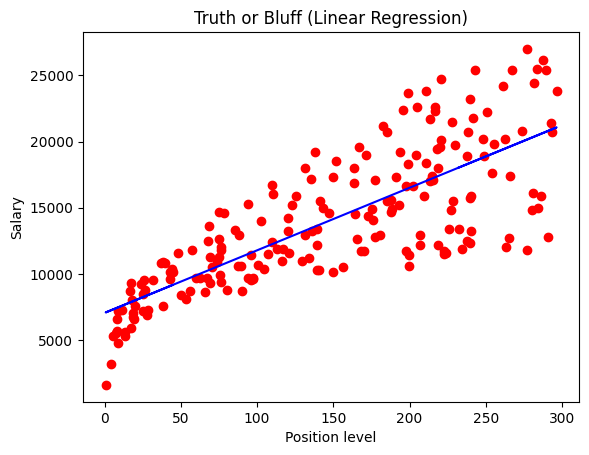

In [954]:
# Visualizing the Linear Regression results
def viz_linear():
    plt.scatter(X, y, color='red')
    plt.plot(X, lin_reg.predict(X), color='blue')
    plt.title('Truth or Bluff (Linear Regression)')
    plt.xlabel('Position level')
    plt.ylabel('Salary')
    plt.show()
    return
viz_linear()

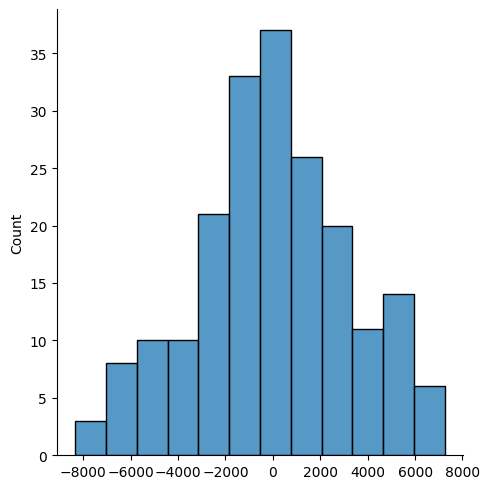

In [955]:
sns.displot(y - lin_reg.predict(X));

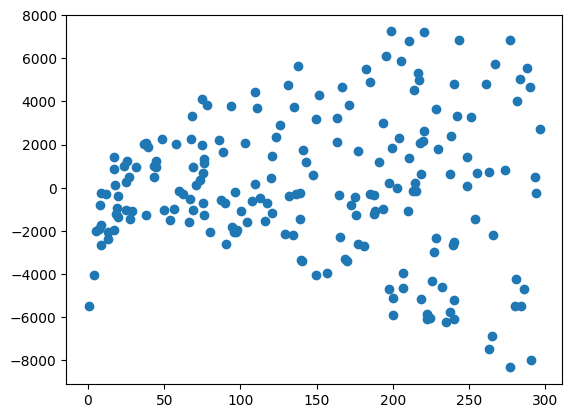

In [956]:
plt.scatter(X, y - lin_reg.predict(X));

In [957]:
X

array([[ 44.5],
       [ 17.2],
       [151.5],
       [180.8],
       [  8.7],
       [ 57.5],
       [120.2],
       [  8.6],
       [199.8],
       [ 66.1],
       [214.7],
       [ 23.8],
       [ 97.5],
       [204.1],
       [195.4],
       [ 67.8],
       [281.4],
       [ 69.2],
       [147.3],
       [218.4],
       [237.4],
       [ 13.2],
       [228.3],
       [ 62.3],
       [262.9],
       [142.9],
       [240.1],
       [248.8],
       [ 70.6],
       [292.9],
       [112.9],
       [ 97.2],
       [265.6],
       [ 95.7],
       [290.7],
       [266.9],
       [ 74.7],
       [ 43.1],
       [228. ],
       [202.5],
       [177. ],
       [293.6],
       [206.9],
       [ 25.1],
       [175.1],
       [ 89.7],
       [239.9],
       [227.2],
       [ 66.9],
       [199.8],
       [100.4],
       [216.4],
       [182.6],
       [262.7],
       [198.9],
       [  7.3],
       [136.2],
       [210.8],
       [210.7],
       [ 53.5],
       [261.3],
       [239.3],
       [

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly_feats = PolynomialFeatures(degree = 2)
poly_feats.fit(X)
X_poly = poly_feats.transform(X)
X_poly

array([[1.000000e+00, 4.450000e+01, 1.980250e+03],
       [1.000000e+00, 1.720000e+01, 2.958400e+02],
       [1.000000e+00, 1.515000e+02, 2.295225e+04],
       [1.000000e+00, 1.808000e+02, 3.268864e+04],
       [1.000000e+00, 8.700000e+00, 7.569000e+01],
       [1.000000e+00, 5.750000e+01, 3.306250e+03],
       [1.000000e+00, 1.202000e+02, 1.444804e+04],
       [1.000000e+00, 8.600000e+00, 7.396000e+01],
       [1.000000e+00, 1.998000e+02, 3.992004e+04],
       [1.000000e+00, 6.610000e+01, 4.369210e+03],
       [1.000000e+00, 2.147000e+02, 4.609609e+04],
       [1.000000e+00, 2.380000e+01, 5.664400e+02],
       [1.000000e+00, 9.750000e+01, 9.506250e+03],
       [1.000000e+00, 2.041000e+02, 4.165681e+04],
       [1.000000e+00, 1.954000e+02, 3.818116e+04],
       [1.000000e+00, 6.780000e+01, 4.596840e+03],
       [1.000000e+00, 2.814000e+02, 7.918596e+04],
       [1.000000e+00, 6.920000e+01, 4.788640e+03],
       [1.000000e+00, 1.473000e+02, 2.169729e+04],
       [1.000000e+00, 2.184000e

In [959]:
poly_feats.get_feature_names_out()

array(['1', 'x0', 'x0^2'], dtype=object)

In [960]:
pol_reg = LinearRegression()
pol_reg.fit(X_poly, y)

LinearRegression()

In [961]:
pol_reg.coef_

array([ 0.        , 67.03796434, -0.06849838])

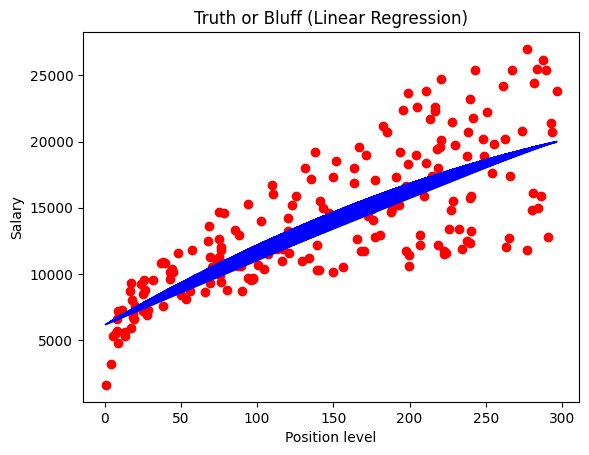

In [962]:
# Visualizing the Polymonial Regression results
def viz_polymonial():
    plt.scatter(X, y, color='red')
    plt.plot(X, pol_reg.predict(X_poly), color='blue')
    plt.title('Truth or Bluff (Linear Regression)')
    plt.xlabel('Position level')
    plt.ylabel('Salary')
    plt.show()
    return
viz_polymonial()

In [963]:
X_poly

array([[1.000000e+00, 4.450000e+01, 1.980250e+03],
       [1.000000e+00, 1.720000e+01, 2.958400e+02],
       [1.000000e+00, 1.515000e+02, 2.295225e+04],
       [1.000000e+00, 1.808000e+02, 3.268864e+04],
       [1.000000e+00, 8.700000e+00, 7.569000e+01],
       [1.000000e+00, 5.750000e+01, 3.306250e+03],
       [1.000000e+00, 1.202000e+02, 1.444804e+04],
       [1.000000e+00, 8.600000e+00, 7.396000e+01],
       [1.000000e+00, 1.998000e+02, 3.992004e+04],
       [1.000000e+00, 6.610000e+01, 4.369210e+03],
       [1.000000e+00, 2.147000e+02, 4.609609e+04],
       [1.000000e+00, 2.380000e+01, 5.664400e+02],
       [1.000000e+00, 9.750000e+01, 9.506250e+03],
       [1.000000e+00, 2.041000e+02, 4.165681e+04],
       [1.000000e+00, 1.954000e+02, 3.818116e+04],
       [1.000000e+00, 6.780000e+01, 4.596840e+03],
       [1.000000e+00, 2.814000e+02, 7.918596e+04],
       [1.000000e+00, 6.920000e+01, 4.788640e+03],
       [1.000000e+00, 1.473000e+02, 2.169729e+04],
       [1.000000e+00, 2.184000e

In [964]:
pol_reg.score(X_poly,y)

0.6175925434032412

### Regresión grado 3

In [965]:
from sklearn.preprocessing import PolynomialFeatures
poly_feats = PolynomialFeatures(degree = 3)
poly_feats.fit(X)
X_poly = poly_feats.transform(X)
X_poly

array([[1.00000000e+00, 4.45000000e+01, 1.98025000e+03, 8.81211250e+04],
       [1.00000000e+00, 1.72000000e+01, 2.95840000e+02, 5.08844800e+03],
       [1.00000000e+00, 1.51500000e+02, 2.29522500e+04, 3.47726588e+06],
       [1.00000000e+00, 1.80800000e+02, 3.26886400e+04, 5.91010611e+06],
       [1.00000000e+00, 8.70000000e+00, 7.56900000e+01, 6.58503000e+02],
       [1.00000000e+00, 5.75000000e+01, 3.30625000e+03, 1.90109375e+05],
       [1.00000000e+00, 1.20200000e+02, 1.44480400e+04, 1.73665441e+06],
       [1.00000000e+00, 8.60000000e+00, 7.39600000e+01, 6.36056000e+02],
       [1.00000000e+00, 1.99800000e+02, 3.99200400e+04, 7.97602399e+06],
       [1.00000000e+00, 6.61000000e+01, 4.36921000e+03, 2.88804781e+05],
       [1.00000000e+00, 2.14700000e+02, 4.60960900e+04, 9.89683052e+06],
       [1.00000000e+00, 2.38000000e+01, 5.66440000e+02, 1.34812720e+04],
       [1.00000000e+00, 9.75000000e+01, 9.50625000e+03, 9.26859375e+05],
       [1.00000000e+00, 2.04100000e+02, 4.16568100e

In [966]:
poly_feats.get_feature_names_out()

array(['1', 'x0', 'x0^2', 'x0^3'], dtype=object)

In [967]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_poly,y, test_size = 0.2, random_state=0)

In [968]:
pol_reg = LinearRegression()
pol_reg.fit(X_train, y_train)

LinearRegression()

In [969]:
predictions = pol_reg.predict(X_test)

In [970]:
df_preds = pd.DataFrame(predictions, columns = ['predictions'])
df_preds['real_value'] = pd.Series(y_test)

df_preds

,predictions,real_value
0,14766.391089,14600.0
1,9602.805378,8400.0
2,12088.774731,8700.0
3,18353.654460,22200.0
4,15650.126740,11700.0
5,18448.060926,17600.0
6,10108.884843,11800.0
7,11112.315667,10900.0
8,12469.529926,9700.0
9,11828.196984,13300.0


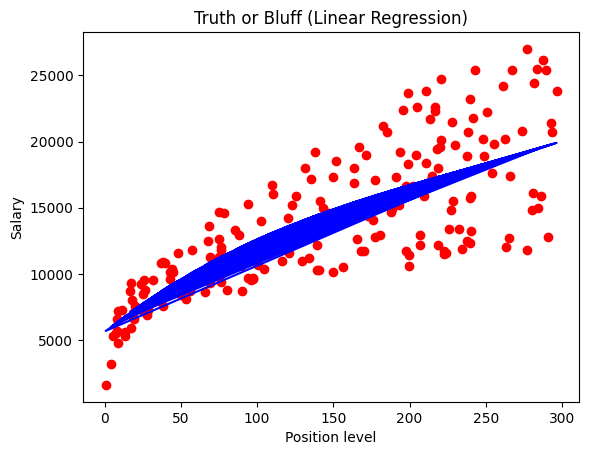

In [971]:
# Visualizing the Polymonial Regression results
def viz_polymonial():
    plt.scatter(X, y, color='red')
    plt.plot(X, pol_reg.predict(X_poly), color='blue')
    plt.title('Truth or Bluff (Linear Regression)')
    plt.xlabel('Position level')
    plt.ylabel('Salary')
    plt.show()
    return
viz_polymonial()

In [972]:
pol_reg.score(X_poly,y)

0.6187720661794751

In [973]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np

In [974]:
X = muebles.iloc[:, 1:2].values
y = muebles.iloc[:, -1].values

poly_feats = PolynomialFeatures(degree = 5)
poly_feats.fit(X)
X_poly = poly_feats.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_poly,y, test_size = 0.2, random_state=12)

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

predictions = lin_reg.predict(X_test)

print("MAE:", mean_absolute_error(y_test, predictions))
print("MAPE:", mean_absolute_percentage_error(y_test, predictions))
print("MSE:", mean_squared_error(y_test, predictions))
print("RMSE:", np.sqrt(mean_squared_error(y_test, predictions)))
print("r2_score train", lin_reg.score(X_train, y_train))
print("r2_score test",lin_reg.score(X_test, y_test))

MAE: 2515.2393333384307
MAPE: 0.1787779314088971
MSE: 9365157.65862409
RMSE: 3060.254508798915
r2_score train 0.6141158359677363
r2_score test 0.6693904665015586


## 1.Regresión lineal

In [976]:
# Variables originales sin polinomios
X = muebles[['TV', 'radio', 'newpaper']]
y = muebles['sales']

# Train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Estandarización
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scal = scaler.transform(X_train)
X_test_scal = scaler.transform(X_test)

In [978]:
lr = linear_model.LinearRegression()

lr.fit(X_train_scal, y_train)

y_pred = lr.predict(X_test_scal)
baseline_error = metrics.mean_squared_error(y_test, y_pred)

print("Train MSE:", metrics.mean_squared_error(y_train, lr.predict(X_train_scal)))
print("Test MSE:", metrics.mean_squared_error(y_test, lr.predict(X_test_scal)))
print("Train RMSE:", np.sqrt(metrics.mean_squared_error(y_train, lr.predict(X_train_scal))))
print("Test RMSE:", np.sqrt(metrics.mean_squared_error(y_test, lr.predict(X_test_scal))))

Train MSE: 2872614.923945353
Test MSE: 2520107.840150606
Train RMSE: 1694.8790292954104
Test RMSE: 1587.4847527301185


In [981]:
from sklearn.linear_model import Ridge

ridgeR = Ridge(alpha = 0.001)
ridgeR.fit(X_train_scal, y_train)

print("Train MSE sin regularización:", round(metrics.mean_squared_error(y_train, lr.predict(X_train_scal)),2))
print("Test MSE sin regularización:", round(metrics.mean_squared_error(y_test, lr.predict(X_test_scal)),2))

print("Train MSE con regularización:", round(metrics.mean_squared_error(y_train, ridgeR.predict(X_train_scal)),2))
print("Test MSE con regularización:", round(metrics.mean_squared_error(y_test, ridgeR.predict(X_test_scal)),2))
print("Train RMSE:", np.sqrt(metrics.mean_squared_error(y_train, ridgeR.predict(X_train_scal))))
print("Test RMSE:", np.sqrt(metrics.mean_squared_error(y_test, ridgeR.predict(X_test_scal))))

Train MSE sin regularización: 2872614.92
Test MSE sin regularización: 2520107.84
Train MSE con regularización: 2872614.92
Test MSE con regularización: 2520079.12
Train RMSE: 1694.8790295860078
Test RMSE: 1587.475706351694


In [987]:
n_alphas = 100
alphas = np.logspace(-4, 3, n_alphas) # Se generan alphas desde 10^-4 a 10^3
print(np.min(alphas))
print(np.max(alphas))
alphas

0.0001
1000.0


array([1.00000000e-04, 1.17681195e-04, 1.38488637e-04, 1.62975083e-04,
       1.91791026e-04, 2.25701972e-04, 2.65608778e-04, 3.12571585e-04,
       3.67837977e-04, 4.32876128e-04, 5.09413801e-04, 5.99484250e-04,
       7.05480231e-04, 8.30217568e-04, 9.77009957e-04, 1.14975700e-03,
       1.35304777e-03, 1.59228279e-03, 1.87381742e-03, 2.20513074e-03,
       2.59502421e-03, 3.05385551e-03, 3.59381366e-03, 4.22924287e-03,
       4.97702356e-03, 5.85702082e-03, 6.89261210e-03, 8.11130831e-03,
       9.54548457e-03, 1.12332403e-02, 1.32194115e-02, 1.55567614e-02,
       1.83073828e-02, 2.15443469e-02, 2.53536449e-02, 2.98364724e-02,
       3.51119173e-02, 4.13201240e-02, 4.86260158e-02, 5.72236766e-02,
       6.73415066e-02, 7.92482898e-02, 9.32603347e-02, 1.09749877e-01,
       1.29154967e-01, 1.51991108e-01, 1.78864953e-01, 2.10490414e-01,
       2.47707636e-01, 2.91505306e-01, 3.43046929e-01, 4.03701726e-01,
       4.75081016e-01, 5.59081018e-01, 6.57933225e-01, 7.74263683e-01,
      

In [991]:
n_alphas = 100
alphas = np.logspace(-4, 3, n_alphas) 

coef_ridge = []
err_ridge = []
baseline = []

for a in alphas:
    ridge = Ridge(alpha=a)
    ridge.fit(X_train_scal, y_train)
    
    coef_ridge.append(ridge.coef_)
    
    y_pred = ridge.predict(X_test_scal)
    ridge_error = metrics.mean_squared_error(y_pred, y_test)
    #ridge_error = np.sqrt(metrics.mean_squared_error(y_pred, y_test))
    
    err_ridge.append(ridge_error)
    baseline.append(baseline_error)

In [992]:
min(err_ridge) 

2290914.8424986457

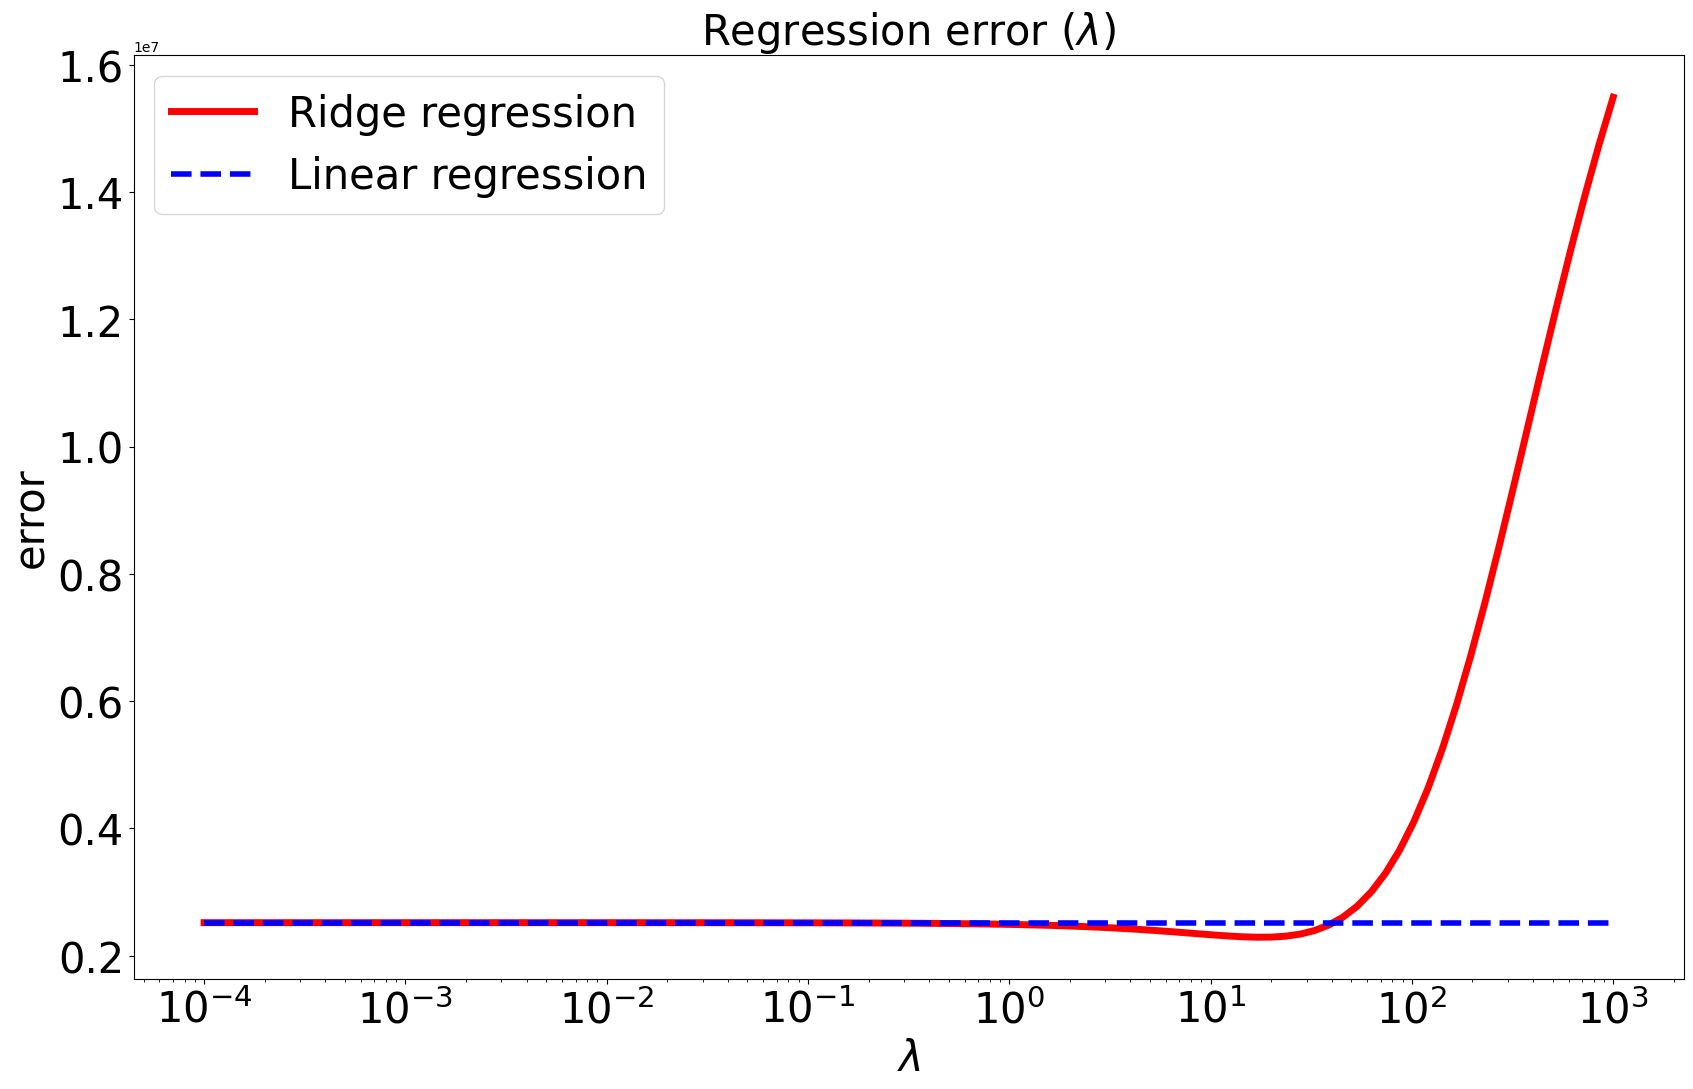

In [993]:
plt.figure(figsize=(20,12))
ax = plt.gca()
ax.plot(alphas, err_ridge, linewidth=5, color='red', label="Ridge regression")
ax.plot(alphas, baseline, linewidth=4,linestyle='--', color='blue', label='Linear regression')
ax.set_xscale('log')
plt.xlabel('$\lambda$', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel('error', fontsize=30)
ax.legend(fontsize=30)
plt.title(r'Regression error ($\lambda$)', fontsize=30)
plt.show()

In [994]:
from sklearn.linear_model import Ridge 
  
# Train the model  
ridgeR = Ridge(alpha = 18) 
ridgeR.fit(X_train_scal, y_train) 

print("Train MSE: %0.4f" % metrics.mean_squared_error(y_train, ridgeR.predict(X_train_scal)))
print("Test MSE: %0.4f" % metrics.mean_squared_error(y_test, ridgeR.predict(X_test_scal)))

Train MSE: 3126008.8677
Test MSE: 2290454.1120


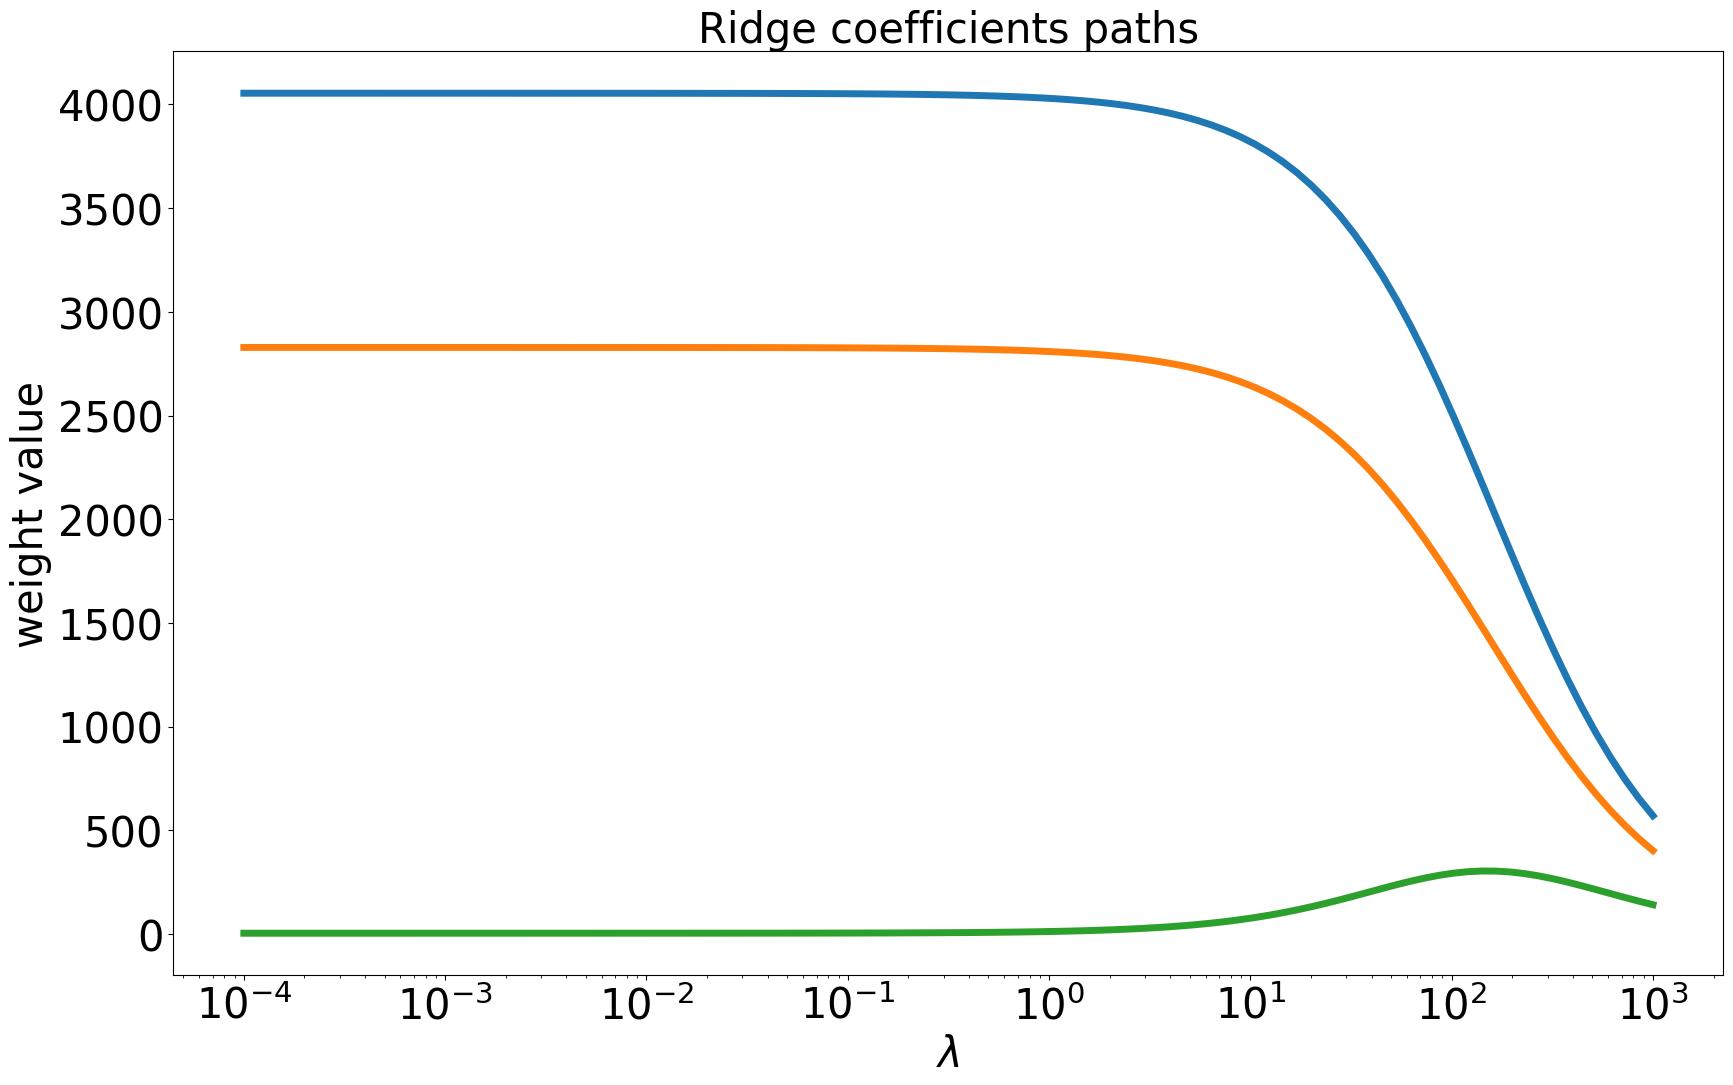

In [995]:
plt.figure(figsize=(20,12))
ax = plt.gca()
ax.plot(alphas, coef_ridge, linewidth=5)
ax.set_xscale('log')
plt.xlabel('$\lambda$', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel('weight value', fontsize=30)
plt.title('Ridge coefficients paths', fontsize=30)
plt.show()

## 2. Lasso

In [1038]:
from sklearn.linear_model import Lasso

lassoR = Lasso(alpha=369)
lassoR.fit(X_train_scal, y_train)

print("Train MSE sin regularización:", round(metrics.mean_squared_error(y_train, lr.predict(X_train_scal)),2))
print("Test MSE sin regularización:", round(metrics.mean_squared_error(y_test, lr.predict(X_test_scal)),2))

print("Train MSE: %0.4f" % metrics.mean_squared_error(y_train, lassoR.predict(X_train_scal)))
print("Test MSE: %0.4f" % metrics.mean_squared_error(y_test, lassoR.predict(X_test_scal)))

Train MSE sin regularización: 2872614.92
Test MSE sin regularización: 2520107.84
Train MSE: 3132893.7157
Test MSE: 2274006.3351


In [1062]:
lasso = linear_model.Lasso(fit_intercept=False)

n_alphas = 100
alphas = np.logspace(1, 4, n_alphas) 
coef_lasso = []
err_lasso = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train_scal, y_train)
    coef_lasso.append(lasso.coef_)
    y_pred = lasso.predict(X_test_scal)
    lasso_error = metrics.mean_squared_error(y_pred, y_test)
    err_lasso.append(lasso_error)

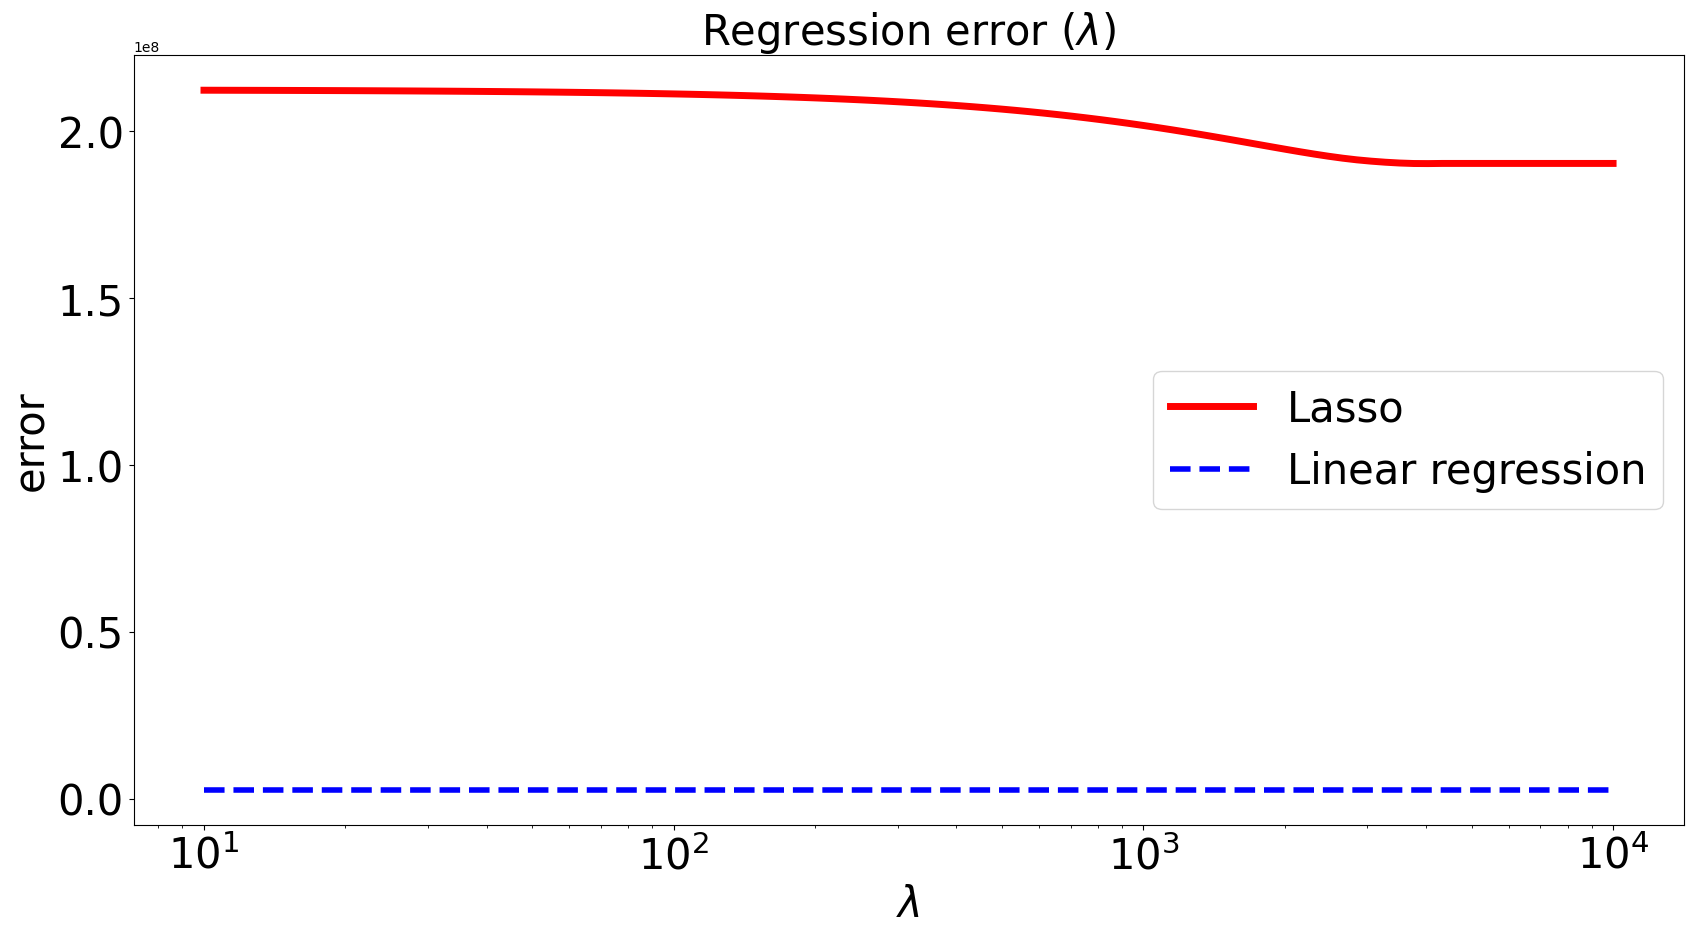

In [1063]:
plt.figure(figsize=(20,10))
ax = plt.gca()
ax.plot(alphas, err_lasso, linewidth=5, color='red', label="Lasso")
ax.plot(alphas, baseline, linewidth=4,linestyle='--', color='blue', label='Linear regression')
ax.set_xscale('log')
plt.xlabel('$\lambda$', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel('error', fontsize=30)
ax.legend(fontsize=30)
plt.title(r'Regression error ($\lambda$)', fontsize=30)
plt.show()

In [1050]:
lassoR = Lasso(alpha = 369) 
lassoR.fit(X_train_scal, y_train) 

print("Train MSE: %0.4f" % metrics.mean_squared_error(y_train, lassoR.predict(X_train_scal)))
print("Test MSE: %0.4f" % metrics.mean_squared_error(y_test, lassoR.predict(X_test_scal)))

Train MSE: 3132893.7157
Test MSE: 2274006.3351


In [1064]:
print("Test MAPE: %0.4f" % metrics.mean_absolute_percentage_error(y_test, lassoR.predict(X_test_scal)))

Test MAPE: 0.1084


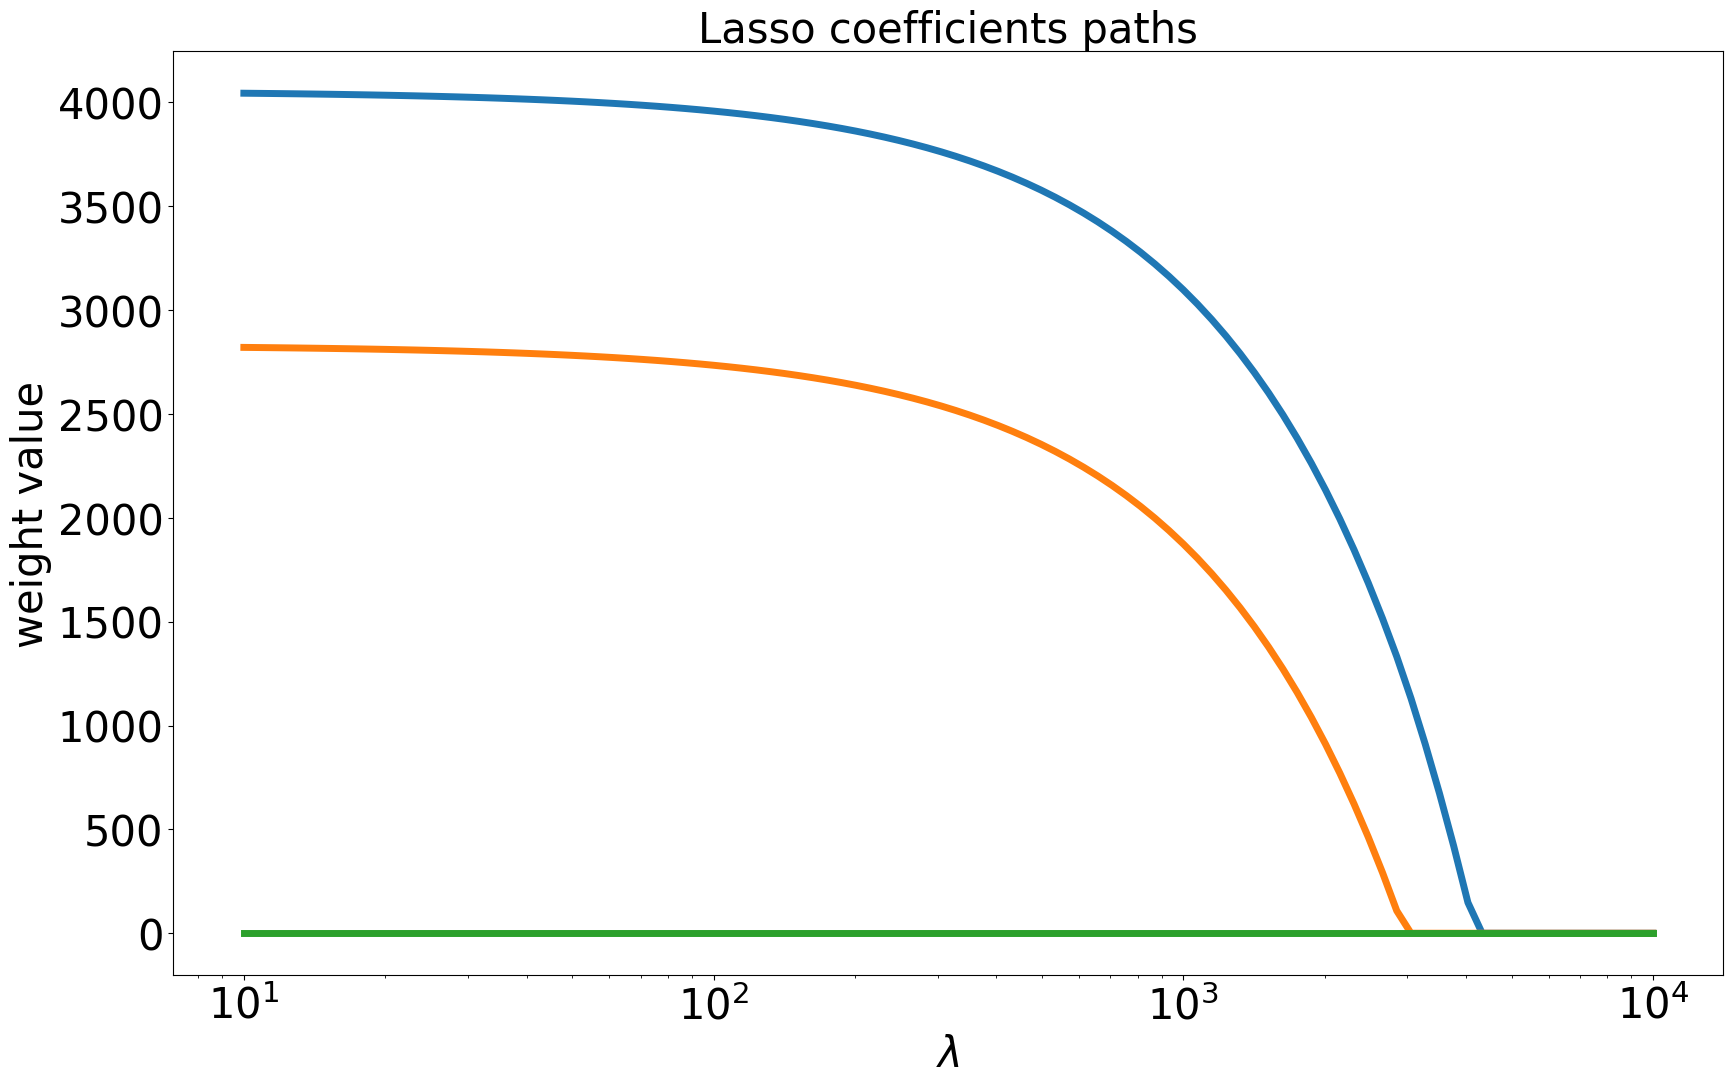

In [1065]:
plt.figure(figsize=(20,12))
ax = plt.gca()
ax.plot(alphas, coef_lasso, linewidth=5)
ax.set_xscale('log')
plt.xlabel('$\lambda$', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel('weight value', fontsize=30)
plt.title('Lasso coefficients paths', fontsize=30)
plt.show()

## 3.Elastic Net

In [1066]:
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha = 1, l1_ratio = 0.5)
elastic_net.fit(X_train_scal, y_train)

print("Train MSE: %0.4f" % metrics.mean_squared_error(y_train, elastic_net.predict(X_train_scal)))
print("Test MSE: %0.4f" % metrics.mean_squared_error(y_test, elastic_net.predict(X_test_scal)))

Train MSE: 5547030.0891
Test MSE: 3451285.1048


In [1071]:
n_alphas = 100
alphas = np.logspace(2, 4, n_alphas) 

coef_eln = []
err_eln = []
baseline = []
for a in alphas:
    elastic_net = ElasticNet(alpha = a, l1_ratio=1)
    elastic_net.fit(X_train_scal, y_train)
    coef_eln.append(elastic_net.coef_)
    y_pred = elastic_net.predict(X_test_scal)
    elasticnet_error = metrics.mean_squared_error(y_pred, y_test)
    err_eln.append(elasticnet_error)
    baseline.append(baseline_error)

In [1072]:
min(err_eln)

2274009.0579878544

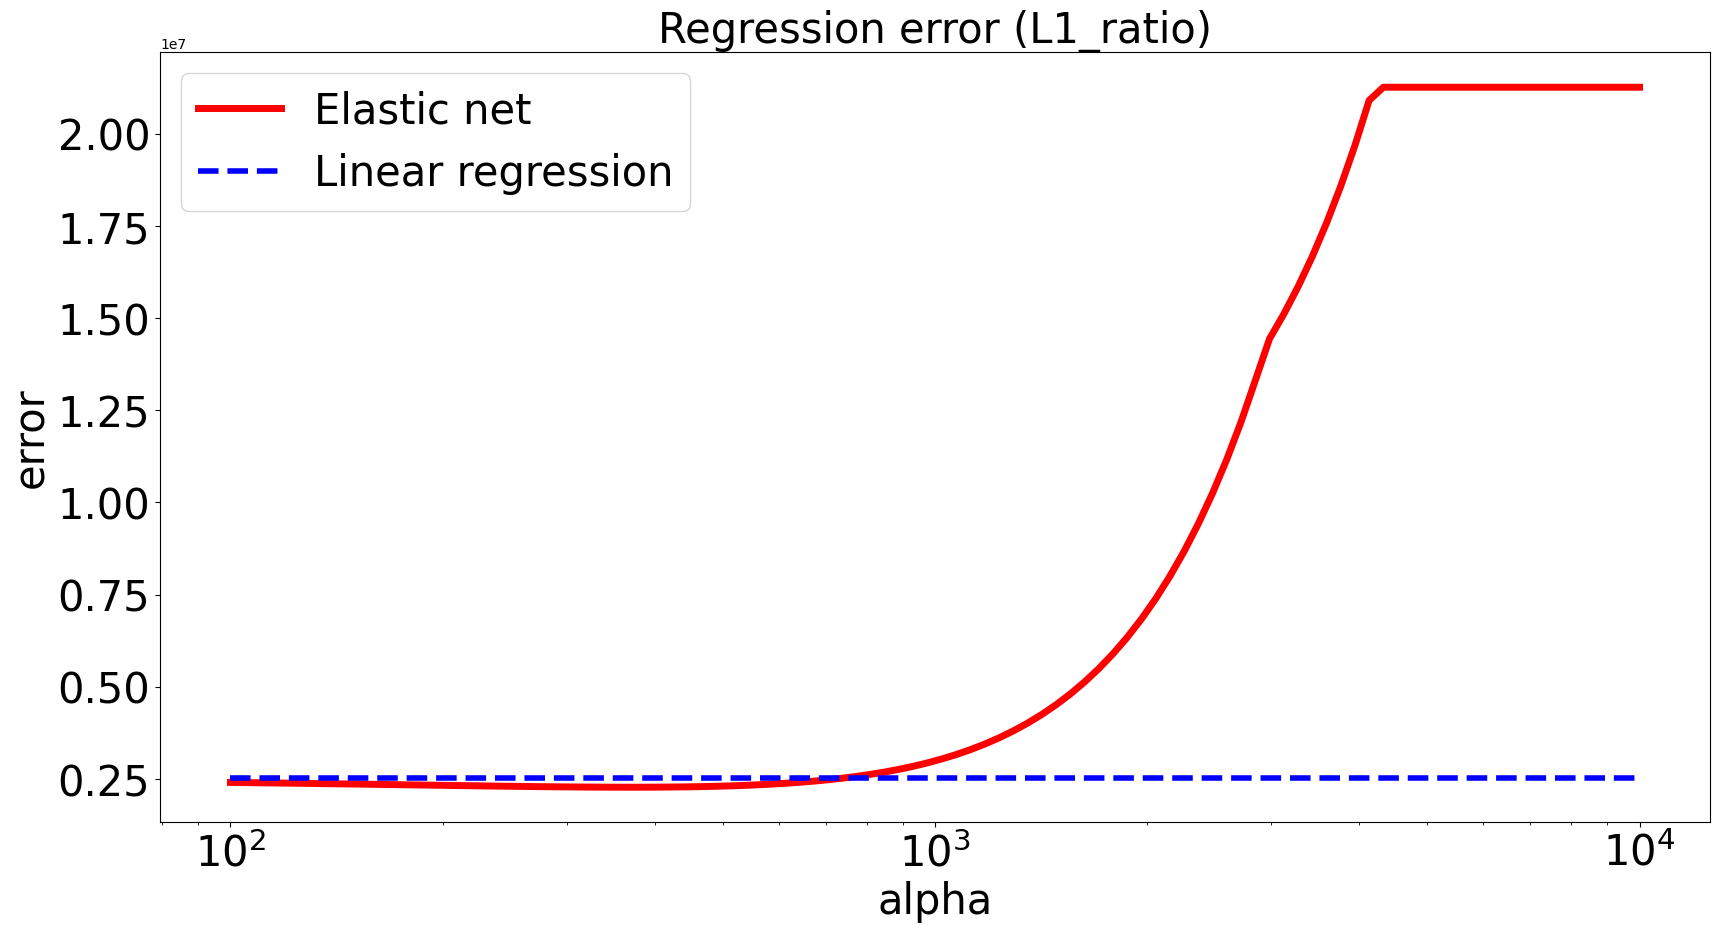

In [1073]:
plt.figure(figsize=(20,10))
ax = plt.gca()
ax.plot(alphas, err_eln, linewidth=5, color='red', label="Elastic net")
ax.plot(alphas, baseline, linewidth=4,linestyle='--', color='blue', label='Linear regression')
ax.set_xscale('log')
plt.xlabel('alpha', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel('error', fontsize=30)
ax.legend(fontsize=30)
plt.title(r'Regression error (L1_ratio)', fontsize=30)
plt.show()

In [1079]:
elastic_net = ElasticNet(alpha = 369, l1_ratio=1)
elastic_net.fit(X_train_scal, y_train) 

print("Train MSE: %0.4f" % metrics.mean_squared_error(y_train, elastic_net.predict(X_train_scal)))
print("Test MSE: %0.4f" % metrics.mean_squared_error(y_test, elastic_net.predict(X_test_scal)))

Train MSE: 3132893.7157
Test MSE: 2274006.3351


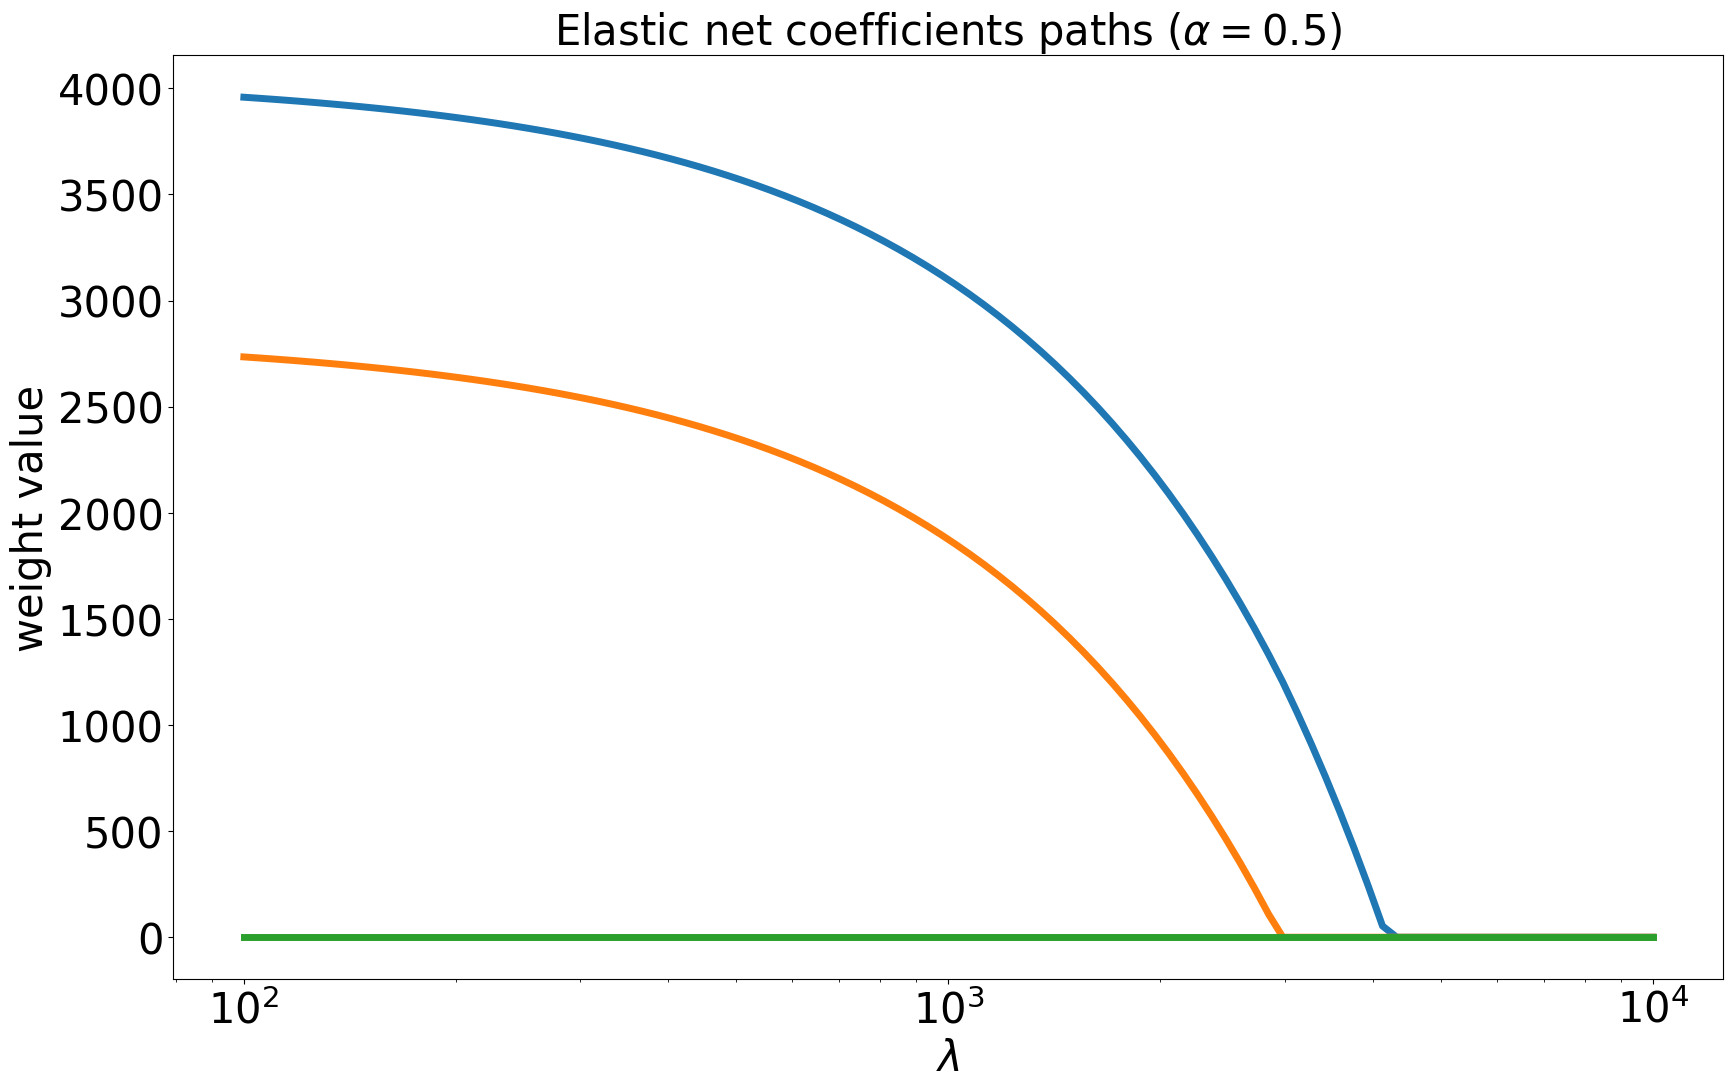

In [1080]:
plt.figure(figsize=(20,12))
ax = plt.gca()
ax.plot(alphas, coef_eln, linewidth=5)
ax.set_xscale('log')
plt.xlabel('$\lambda$', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel('weight value', fontsize=30)
plt.title(r'Elastic net coefficients paths ($\alpha=0.5$)', fontsize=30)
plt.show()

In [1081]:
print("Linear regression error:   %0.4f" % baseline_error)    
print("Minimun ridge error:       %0.4f" % min(err_ridge))
print("Minimum lasso error:       %0.4f" % min(err_lasso))
print("Minimum elastic net error: %0.4f" % min(err_eln))

Linear regression error:   2520107.8402
Minimun ridge error:       2290914.8425
Minimum lasso error:       190226358.7858
Minimum elastic net error: 2274009.0580


# (Explicación contaminación entre train y test)

## Resultados